In [1]:
#Importación de librearías necesarias
import pandas as pd
from datetime import datetime
import socket
import numpy as np
import math
import time
import pickle  #Para guardar archivos
import os

from pympler import asizeof #Para liberar memoria
import gc

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

In [2]:
#Path general de archivos
if socket.gethostname()=='LAPTOP-PUSGG08B': #Ip de la laptop
    ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/Data/TFM/"
    r_ruta = "E:/Cristian Guatemal/Master/Big Data y Ciencia de Datos/VIU_TFM/RData/TFM/"
elif socket.gethostname()=='PCUIOMTDAIE6382': #Ip del working
    ruta =   "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/Data/TFM/"
    r_ruta = "D:/Master/Big_Data_Ciencia_Datos/VIU_TFM/RData/TFM/"
# Ruta del archivo de pensionistas de vejez
ruta_vj = ruta + 'POB_VEJ_CD656_NEW.dsv'
# Ruta del archivo de historia laboral de pensionistas
ruta_afi = ruta + 'APORTES_CD656_new.dsv'

In [ ]:
#Importación de archivos de afiliados
inicio = time.time()
afi = pd.read_csv( ruta_afi, delimiter='\t', encoding='iso-8859-1', decimal='.')
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', 
        (fin-inicio)%60, ' segundos' )

In [ ]:
#Agrupamiento por relación de trabajo
inicio = time.time()
agrupa = [ (afi['SECTOR'].isin(['PRIVADO', 'PASANTE PRIVADO'])), 
           (afi['SECTOR'].isin(['PUBLICO', 'PASANTE PUBLICO'])), 
           (afi['SECTOR'].isin(['INDEPENDIENTES', '108-ARTISTA Y GESTOR DE CULTURA', 
                                '02-TRABAJ. AUT Y SIN RELAC DEPEN DESDE  2011-12 SOLO AF.VOLUNT  '])),
           (afi['SECTOR'].isin(['69-VOLUNTARIO ECUATORIANO DOMICILIADO EN EL EXTERIOR ',
                                '89-AFILIACION DOMICILIADO EN EL EXTERIOR'])),
           (afi['SECTOR'] == '90-AFILIACION DOMICILIADO EN EL PAIS / SIN RELACION DEPENDENCIA'),
           (afi['SECTOR'] == '06-CODIGO DEL TRABAJO - CT ')
            ]
            
tipo = ['PRI', 'PUB', 'IND', 'VOL_EX', 'VOL_EC', 'COD_TR']

afi['SECTOR_A'] = np.select( agrupa, tipo, default=afi['SECTOR'])
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', 
        (fin-inicio)%60, ' segundos' )

In [ ]:
afi['SECTOR'].unique()

In [ ]:
afi['SECTOR_A'].unique()

In [ ]:
afi.shape

In [ ]:
#Para acceder a las prestaciones de IVM debe tener al menos 5 años de aporte o 60 imposiciones
ced_counts = afi.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()

In [ ]:
# numero de cedulas que tienen menos de 60 imposiciones
ced_counts[ced_counts < 60].index.nunique()

In [ ]:
#Se filtran a las cedulas con menos de 60 imposicones 
inicio = time.time()
afi_fil = afi[~afi['CEDULA_COD'].isin(ced_counts[ced_counts < 60].index)].copy()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

#Se crea una variable fecha
inicio = time.time()
afi_fil.loc[:, 'FECHA'] = pd.to_datetime(afi_fil['ANIO'].astype(str) + '-' + afi_fil['MES'].astype(str).str.zfill(2) + '-01')
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

#Se ordenan los registros
inicio = time.time()
afi_fil = afi_fil.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, True, True] )
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
afi_fil.shape

In [ ]:
# Especifica la ruta del directorio donde quieres guardar el archivo
directorio = r_ruta

# Asegúrate de que el directorio existe
os.makedirs(directorio, exist_ok=True)

# Nombre del archivo
nombre_archivo = 'viu_clean_afi.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto1 = afi

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto1, archivo)
    
    
# Nombre del archivo
nombre_archivo = 'viu_clean_afi_fil.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto2 = afi_fil

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto2, archivo)
        
    
# #Cargar los archivos
# with open( ruta_archivo, 'rb') as archivo:
#     pickle.load(archivo)  # Carga y descarta el primer objeto
#     afi_fil = pickle.load(archivo)  # Carga el segundo objeto    

In [ ]:
#Se eliminan archivos no necesarios para liberar la memoria
del afi
del objeto1
del objeto2
del ced_counts

In [ ]:
afi_fil #Tiene una dimensión de (64638969 rows × 14 columns)

In [ ]:
#Se seleccionan las características de la población para los año y mes de aportación
afi_sel = afi_fil[['CEDULA_COD', 'ANIO', 'MES', 'FECHA','SALARIO', 'SECTOR_A']].copy()
del afi_fil

In [ ]:
#Inicio de la HL
caract = afi_sel.groupby('CEDULA_COD')['FECHA'].min().reset_index() 
caract.rename( columns={'FECHA': 'INI_HL'}, inplace=True)
#Fin de la HL
caract['FIN_HL'] = caract['CEDULA_COD'].map( afi_sel.groupby('CEDULA_COD')['FECHA'].max() )
#Contar los meses, considerando duplicidad en los meses que puede tener aporte simultaneos
caract['MES_AS'] = caract['CEDULA_COD'].map( afi_sel['CEDULA_COD'].value_counts() )
#Meses trabajados unicos
aux = afi_sel.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])
caract['MES_TU'] = caract['CEDULA_COD'].map( aux['CEDULA_COD'].value_counts() )

In [ ]:
# Nombre del archivo
nombre_archivo = 'viu_clean_caract.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto3 = caract

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto3, archivo)    

In [ ]:
del objeto3

In [ ]:
caract

In [ ]:
#Personas que tienen varios aportes simultaneos
caract[caract['MES_AS']>caract['MES_TU']]

In [ ]:
#afi_sel[afi_sel['CEDULA_COD']==21729781].tail(60)

In [ ]:
afi_sel =  afi_sel.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, False, False] )
afi_sel['NUM_SEC_MES'] = 1
afi_sel['%_NUM_SECTOR'] = afi_sel['SALARIO']

In [ ]:
aux = afi_sel[afi_sel.duplicated(subset=['CEDULA_COD', 'ANIO', 'MES'], keep=False)]
aux1 = afi_sel[~afi_sel.duplicated(subset=['CEDULA_COD', 'ANIO', 'MES'], keep=False)]

In [ ]:
#Se debe analizar a las personas que tienen varios aportes en un mismo mes
#Se suman los salarios y se concatenan los sectores para la cedula que en el mismo anio y mes tienen más de un sector
inicio = time.time()
afi_sel_g = aux.groupby(['CEDULA_COD', 'ANIO', 'MES']).agg({'SALARIO': 'sum',
                                                            'SECTOR_A': lambda x: ';'.join(x),
                                                            'NUM_SEC_MES': lambda x: len(x),
                                                            '%_NUM_SECTOR': lambda x:  ';'.join((x / x.sum()).round(4).astype(str))
                                                                }).reset_index()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )


In [ ]:
afi_sel_g

In [ ]:
afi_sel_g_all = pd.concat( [aux1[['CEDULA_COD', 'ANIO', 'MES', 'SALARIO', 'SECTOR_A', 'NUM_SEC_MES', '%_NUM_SECTOR']], 
                            afi_sel_g], ignore_index=True )

In [ ]:
afi_sel_g_all

In [ ]:
# Nombre del archivo
nombre_archivo = 'viu_clean_afi_sel_g_all.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto4 = afi_sel_g_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto4, archivo)      

In [ ]:
#afi_sel_g_all = objetos[3]

In [ ]:
del aux
del aux1
del objeto4

In [ ]:
afi_sel_g_all = afi_sel_g_all.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[True, False, False] )
afi_sel_g_all.loc[ (afi_sel_g_all['NUM_SEC_MES'] == 1), '%_NUM_SECTOR'] = '1'

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==216]

In [ ]:
#Se reinician los index
afi_sel_g_all.reset_index(inplace=True)
afi_sel_g_all.rename(columns={'index': 'nuevo_indice'}, inplace=True)
afi_sel_g_all.drop(columns=['nuevo_indice'], inplace=True)

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126]

In [ ]:
#se crean los grupos de 12 meses trabajados para tener
n_grupo = 12
afi_sel_g_all['GRUPO'] = (afi_sel_g_all.groupby('CEDULA_COD').cumcount() // n_grupo ) + 1
#Se saca el salario promedio de cada grupo
afi_sel_g_all['SAL_PROM_GRUPO'] = afi_sel_g_all.groupby(['CEDULA_COD', 'GRUPO'])['SALARIO'].transform('mean')

In [ ]:
afi_sel_g_all

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126]['GRUPO'].unique()

In [ ]:
#Se obtienen los sueldos promedios para cada grupo y cada cedula
inicio = time.time()
df1 = afi_sel_g_all.groupby(['CEDULA_COD', 'GRUPO'])['SAL_PROM_GRUPO'].first().reset_index().copy()
df1 = df1.sort_values(by = ['CEDULA_COD','SAL_PROM_GRUPO'], ascending=[True,False])
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
df1

In [ ]:
 df1[df1['CEDULA_COD']==126]

In [ ]:
#Se seleccionan los 5 mejores años de sueldo
inicio = time.time()
top = 5
#top_sal = df1.groupby('CEDULA_COD')['SAL_PROM_GRUPO'].nlargest(top).reset_index(level=0, drop=True)
indices = df1.groupby('CEDULA_COD').apply(lambda x: x.index[:top]).explode()
df2 = df1.loc[indices].reset_index(drop=True)
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
df2[df2['CEDULA_COD']==126]

In [ ]:
#Seleccionar los cinco mejores años del grupo total de años de aporte
combinaciones = set(zip(df2['CEDULA_COD'], df2['GRUPO']))
afi_sel_g_all['GRUPO_SEL'] = [(cedula, grupo) in combinaciones for cedula, grupo in zip(afi_sel_g_all['CEDULA_COD'], afi_sel_g_all['GRUPO'])]
afi_sel_g_all['GRUPO_SEL'] = afi_sel_g_all['GRUPO_SEL'].astype(int)

In [ ]:
#Verificar que todas las cédulas tengan al menos 60 registros de los salarios
ced_counts1 = afi_sel_g_all.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()
ced_counts1[ced_counts1 < 60].index.nunique()

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126].tail(60)

In [ ]:
#Se crea una variable fecha para el período de mejores años y la base de cálculo
inicio = time.time()
mejores = afi_sel_g_all[afi_sel_g_all['GRUPO_SEL']==1].copy()
mejores.loc[:, 'FECHA'] = pd.to_datetime(mejores['ANIO'].astype(str) + '-' + mejores['MES'].astype(str).str.zfill(2) + '-01')

#Se calcula la base de calculo
df_prom = mejores.groupby('CEDULA_COD')['SALARIO'].mean()
fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )

In [ ]:
mejores

In [ ]:
afi_sel_g_all['INI_CAL'] = afi_sel_g_all['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].max() )
afi_sel_g_all['FIN_CAL'] = afi_sel_g_all['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].min() )
afi_sel_g_all['BASE_CAL'] = afi_sel_g_all['CEDULA_COD'].map( df_prom )

In [ ]:
caract['INI_CAL'] = caract['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].max() )
caract['FIN_CAL'] = caract['CEDULA_COD'].map( mejores.groupby('CEDULA_COD')['FECHA'].min() )
caract['BASE_CAL'] = caract['CEDULA_COD'].map( df_prom )
caract

In [ ]:
del df1, df2, mejores

In [ ]:
afi_sel_g_all[ (afi_sel_g_all['CEDULA_COD']==126) & (afi_sel_g_all['GRUPO_SEL']==1)]['SALARIO'].mean()

In [ ]:
afi_sel_g_all[ (afi_sel_g_all['CEDULA_COD']==126)]

In [ ]:
# #     df = asignar_grupo(sect, n_grupo)
# #     df1 = valores_unicos_grupos(df)
# #     df2 = sel_top_salarios(df1, top)
# #     df = sel_grupo(df, df2)
#     df = fec_sel_grupo(df)
#     df = base_cal(df)
#     df = ati_base_cal_m1(df, inferior)
#     df = base_cal_sin_ati_m1(df)
#     df = sbu_ajuste_m1(df, SBU)

In [ ]:
#Registros con años menores al 2000
afi_sel_g_all[afi_sel_g_all['FIN_CAL'].dt.year<2000]

In [ ]:
#Se agrega el valor del SBU
SBU = pd.DataFrame( { 'ANIO':[2000,2001,2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
                              2021, 2022, 2023, 2024],
                      'VALOR':[57,85.65,105, 122, 136, 150, 160, 170, 200, 218, 240, 264, 292, 318, 340, 354, 366, 375, 386, 394, 400, 
                              400, 425, 450, 460]})
SBU

In [ ]:
afi_sel_g_all['SBU'] = afi_sel_g_all['ANIO'].map( SBU.groupby('ANIO')['VALOR'].first())

In [ ]:
afi_sel_g_all

In [ ]:
#Cédula que tienen su historia laboral igual al SBU
afi_sel_g_all['ID_SBU'] = afi_sel_g_all['SALARIO'] == afi_sel_g_all['SBU']
#Si tiene -1 es un valor que no es un SBU en ese año y mes
afi_sel_g_all['ID_SBU'] = afi_sel_g_all['ID_SBU'].astype(int)-1
afi_sel_g_all

In [ ]:
#Verificar que todas las cédulas tengan 60 registros
ced_counts2 = afi_sel_g_all.drop_duplicates(subset=['CEDULA_COD', 'ANIO', 'MES'])['CEDULA_COD'].value_counts()
ced_counts2[ced_counts2 < 60].index.nunique()

In [ ]:
afi_sel_g_all[afi_sel_g_all['CEDULA_COD']==126].shape

In [ ]:
afi_sel_g_all[(afi_sel_g_all['CEDULA_COD']==126) & (afi_sel_g_all['GRUPO_SEL']==1)]

In [ ]:
# Nombre del archivo
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto5 = afi_sel_g_all

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto5, archivo)          

In [ ]:
del objeto5

In [ ]:
#Selección de cedulas con sus mejores años de sueldo y que su salario no sea un SBU
data_sin_ati = afi_sel_g_all[ (afi_sel_g_all['GRUPO_SEL']==1) & (afi_sel_g_all['ID_SBU']!=-1)]
data_ati = afi_sel_g_all[ (afi_sel_g_all['GRUPO_SEL']==1) & (afi_sel_g_all['ID_SBU']!=0)]

In [ ]:
data_ati.shape #(21022610, 15)
data_sin_ati.shape #(5449506, 15)

In [ ]:
data_ati[data_ati['CEDULA_COD']==126][['CEDULA_COD','ANIO','MES','SALARIO']].shape

In [ ]:
data_ati[data_ati['CEDULA_COD']==126]

In [ ]:
# Nombre del archivo
nombre_archivo = 'viu_clean_data_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto6 = data_ati

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto6, archivo)         

# Nombre del archivo
nombre_archivo = 'viu_clean_data_sin_ati.pkl'
# Ruta completa del archivo
ruta_archivo = os.path.join(directorio, nombre_archivo)
# Objetos a guardar
objeto7 = data_sin_ati

# Guardar los objetos en el archivo
with open(ruta_archivo, 'wb') as archivo:
    pickle.dump(objeto7, archivo)     
    
del objeto6, objeto7

In [3]:
#Cargar los archivos
directorio = r_ruta
nombre_archivo = 'viu_clean_afi_sel_g_all_2.pkl'
ruta_archivo = os.path.join(directorio, nombre_archivo)

with open( ruta_archivo, 'rb') as archivo:
    data_l = pickle.load( archivo )     

In [4]:
#Análisis de atípicos
#Método de clustering jerárquico
data_l.shape #(62130167, 15)

(62130167, 15)

In [5]:
inicio = time.time()
data_l = data_l.sort_values( by=["CEDULA_COD","ANIO", "MES"], ascending=[ True, True, True] )
data_l.reset_index(inplace=True)
data_l.rename(columns={'index': 'nuevo_indice'}, inplace=True)
data_l.drop(columns=['nuevo_indice'], inplace=True)
data_l['INDICE'] = data_l.index

#Casos de no análisis
data_no_grupo = data_l[ (data_l['GRUPO_SEL']==0) ].copy()
data_no_grupo['ATI_CJ_M1'] = np.nan
data_no_grupo['ATI_CJ_M2'] = np.nan
data_no_grupo['ATI_CJ_M3'] = np.nan

#Casos de análisis
data = data_l[ (data_l['GRUPO_SEL']==1) ].copy()

fin = time.time()  
print('Tiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )


Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 55.33782982826233  segundos


In [6]:
#Para ejecutar el cluster jerarquico
def cluster_jerarquico( data_si_dic, k):
    inicio = time.time()
    nom = 'ATI_CJ_M' + str( k+1 )
    data_val_ati = {}
    for cedula in data_si_dic:

        if( len( data_si_dic[ cedula ]['SALARIO'] ) > 1 ): #Para formar al menos un cluster

            aux = np.array( data_si_dic[ cedula ]['SALARIO'] ).reshape(-1, 1)
            Z = linkage( aux , method='single', metric='euclidean')

            num_clusters = 2  # Puedes ajustar este valor según tus necesidades
            clusters = fcluster(Z, num_clusters, criterion='maxclust')

            if( len( np.unique(clusters) ) > 1 ): #Para considerar al menos 2 cluster
                # Calcular el centroide de cada clúster
                cluster_centers = np.array([[ np.nanmean(aux[clusters == i], axis=0)[0], i ] for i in range(1, num_clusters + 1)] ) 

                Q1 = np.quantile(aux, 0.25)
                Q3 = np.quantile(aux, 0.75)
                IQR = Q3-Q1
                LI = Q1 - 1.5 * IQR
                LS = Q3 + 1.5 * IQR

                cl_at = np.where( cluster_centers[:,0] > (LS +  1e-8) )[0]
                cluster_centers[cl_at][:, 1]

                mod_aux = np.zeros((len(aux), 2))
                mod_aux[:, 0] = aux[:, 0]  # Copiar los valores originales de aux en la primera columna
                mod_aux[np.isin(clusters, cluster_centers[cl_at][:, 1]), 1] = 1  # Asignar 1 en la segunda columna donde el cluster es 1

                data_val_ati[cedula] = {'SALARIO': mod_aux[:, 0].tolist(),
                                             nom : mod_aux[:, 1].tolist(),
                                        'INDICE' : data_si_dic[ cedula ]['INDICE']}
            else:
                data_val_ati[cedula] = { 'SALARIO': aux.flatten().tolist(),
                                               nom:  [-1] * len(aux),
                                         'INDICE' : data_si_dic[ cedula ]['INDICE']} 

        else:
            data_val_ati[cedula] = { 'SALARIO': data_si_dic[ cedula ]['SALARIO'],
                                           nom:  [-2] * len( data_si_dic[ cedula ]['SALARIO'] ),
                                     'INDICE' : data_si_dic[ cedula ]['INDICE']}
    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    
    return data_val_ati
 
#Para unir los resultados
def extend_data( data_val_ati, k ):
    inicio = time.time()
    nom = 'ATI_CJ_M' + str( k + 1 )
    data1 = { 'CEDULA_COD': [], 'SALARIO': [], nom : [], 'INDICE':[]}

    # Llenar las listas con los datos del diccionario
    for cedula, values in data_val_ati.items():
        salario = values['SALARIO']
        atipico = values[ nom ]
        indice = values['INDICE']
        num_rows = len(salario)

        # Extender las listas en el diccionario de datos
        data1['CEDULA_COD'].extend([cedula] * num_rows)
        data1['SALARIO'].extend(salario)
        data1[ nom ].extend(atipico)
        data1['INDICE'].extend(indice)

    fin = time.time()  
    print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
    return data1

In [7]:
#Se crea un bucle para cada caso
for k in range(0,3):
    nom = 'ATI_CJ_M' + str( k+1 )
    if (k==0):
        ##Primer Caso--Considerando solo los salarios mayores al SBU y desde el año 2000
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data[   ( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 ) ].copy() 
        data_no = data[ ~(( data['SALARIO'] >= data['SBU'] ) & ( data['ANIO'] >= 2000 )) ].copy() 
        data_no[ nom ] = np.nan
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) #(26006294, 16)
        print('Tamaño de la data no utilizada dentro de los años seleccionados',data_no.shape)  #(465822, 16)
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        data_no_dic = data_no.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO',  nom , 'INDICE']],
                                  pd.DataFrame( data1 ), 
                                  data_no[['CEDULA_COD', 'SALARIO',  nom , 'INDICE']] ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom )] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif1 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')  
        
    if (k==1):
        ##Segundo Caso--Considerando todo el registro de los mejores años
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data.copy()
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) 
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', nom, 'INDICE']],
                                  pd.DataFrame( data1 ) ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom ) ] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif2 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')
        
    if (k==2):
        ##Tercer Caso--Considerando todo el registro de los mejores años, pero a partir del año 2000
        print('*' * 50, 'Caso ', str( k+1 ), '*' * 50)
        data_si = data[  ( ( data['ANIO'] >= 2000 )) ].copy()
        data_no = data[ ~( ( data['ANIO'] >= 2000 )) ].copy()   
        data_no[ nom ] = np.nan
        print('Tamaño de la data utilizada dentro de los años seleccionados', data_si.shape) 
        print('Tamaño de la data no utilizada dentro de los años seleccionados',data_no.shape) 
        
        data_si_dic = data_si.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        data_no_dic = data_no.groupby('CEDULA_COD').agg({'SALARIO': list, 'INDICE': list}).to_dict(orient='index')
        
        print('Algoritmo Cluster Jerárquico')
        data_val_ati = cluster_jerarquico( data_si_dic, k )
        print('Extensión del diccionario')
        data1 = extend_data( data_val_ati, k )
        
        print('Concatenación de dataframe')
        inicio = time.time()
        data_jerar = None
        data_jerar = pd.concat( [ data_no_grupo[['CEDULA_COD', 'SALARIO', nom, 'INDICE']],
                                  pd.DataFrame( data1 ), 
                                  data_no[['CEDULA_COD', 'SALARIO', nom, 'INDICE']] ], axis=0)
    
        data_jerar = data_jerar.sort_values( by=["INDICE"], ascending=[ True ] )
        data_jerar.reset_index(inplace=True)
        data_jerar.rename(columns={'index': 'nuevo_indice'}, inplace=True)
        data_jerar.drop(columns=['nuevo_indice'], inplace=True)
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Creación de la columna')
        inicio = time.time()
        data_l[ nom ] = np.nan
        aux = data_jerar[ nom ].to_numpy()
        data_l.iloc[:, data_l.columns.get_loc( nom )] = aux
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        
        print('Verificación de posibles errores')
        inicio = time.time()
        dif3 = data_l[data_l['SALARIO']!= data_jerar['SALARIO']].index
        fin = time.time()  
        print('\tTiempo de ejecución es: ',  (fin-inicio)//3600, ' horas con ' ,  (fin-inicio)%3600//60 , ' minutos y', (fin-inicio)%60, ' segundos' )
        print('*' * 108, '\n')



        

************************************************** Caso  1 **************************************************
Tamaño de la data utilizada dentro de los años seleccionados (26006294, 16)
Tamaño de la data no utilizada dentro de los años seleccionados (465822, 17)
Algoritmo Cluster Jerárquico
	Tiempo de ejecución es:  0.0  horas con  3.0  minutos y 44.86534404754639  segundos
Extensión del diccionario
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 2.6210649013519287  segundos
Concatenación de dataframe
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 28.516056299209595  segundos
Creación de la columna
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 0.34307408332824707  segundos
Verificación de posibles errores
	Tiempo de ejecución es:  0.0  horas con  0.0  minutos y 6.838729619979858  segundos
************************************************************************************************************ 

************************************************** Caso  2 

In [72]:
#El valor de NA implica que esos datos no son parte de data_si, por lo que no se analizaron
#El valor de -1 implica que se formó un solo cluster
#El valor de -2 implica que en la selección de datos (data_si), la cedula solo tenía un único valor para formar los cluster
#por lo que, para el caso 2, no deben hacer valores de -2, porque se toma en cuenta toda la HL

##Primero se analiza el caso de los valores -2 método 1
# data_l[ ( data_l['GRUPO_SEL']==1 )]['ATI_CJ_M3'].unique()
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1']==-2)] 
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1'].isna())]  #465822 rows × 21 columns
# data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M1']==-1)]  # 3292785 rows × 21 columns

#data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M2']==-1)]  #3125765

#data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3']==-2)]  #2 rows × 21 columns
#data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3'].isna())]  # 7454 rows × 21 columns
data_l[ ( data_l['GRUPO_SEL']==1 ) & (data_l['ATI_CJ_M3']==-1)] #3125140 rows × 21 columns

,CEDULA_COD,ANIO,MES,SALARIO,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,GRUPO_SEL,...,FIN_CAL,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2


In [10]:
#Se calculan los limítes máximos de aportación en función de la HL
##Primer Caso -- Para toda la historia laboral
grupo1 = data_l.copy()
Q1 = grupo1.groupby('CEDULA_COD')['SALARIO'].quantile(0.25)
Q3 = grupo1.groupby('CEDULA_COD')['SALARIO'].quantile(0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
data_l['LS1'] = data_l['CEDULA_COD'].map( LS )
##Segundo Caso --Para la historia laboral a partir del año 2020
grupo2 = data_l[data_l['ANIO']>=2000].copy()
Q1 = grupo2.groupby('CEDULA_COD')['SALARIO'].quantile(0.25)
Q3 = grupo2.groupby('CEDULA_COD')['SALARIO'].quantile(0.75)
IQR = Q3-Q1
LI = Q1 - 1.5 * IQR
LS = Q3 + 1.5 * IQR
data_l['LS2'] = data_l['CEDULA_COD'].map( LS )

In [34]:
#Caso 1- Correcciones
#Se hacen las correcciones para los valores -2, en donde si el Salario es menor o igual a un SBU no es atípico( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0 # nos quedan solo 23 casos que analizar, aplicado esto
#Ahora se corrige en función deL Límite máximo de la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] > data_l['LS2']) ), 'ATI_CJ_M1'] = 1
#Ahora se corrige en función del valores menoRes al limite máximo la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-2) & (data_l['SALARIO'] <= data_l['LS2']) ), 'ATI_CJ_M1'] = 0

#Se hacen las correcciones para los valores NA, en donde si el Salario es menor o igual a un SBU no es atípico( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0  #quedan 7454 casos
#Ahora se corrige en función deL Límite máximo de toda la HL, pues sno hay datos del SBU para atrás ( NA -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M1'] = 1  #quedan 7190 casos
#Ahora se corrige en función del valores menoRes al limite máximo la HL, pues sno hay datos del SBU para atrás ( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1'].isna()) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M1'] = 0  #quedan 7190 casos

#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M1'] = 0 #quedan 2745303
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M1'] = 1 #quedan 2730050
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M1'] = 0 #quedan 2730050

In [48]:
#Caso 2 - Correcciones
#No existen valores igual a NA e igual a -2
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M2'] = 0 #quedan  2685385 casos
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M2'] = 1 # quedan 2671407
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M2']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M2'] = 0

In [71]:
#Caso 3 - Correcciones
#Se hacen las correcciones para los valores -2, en donde si el Salario es menor o igual a un SBU no es atípico( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 #quedan 2 casos
#Ahora se corrige en función deL Límite máximo de la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] > data_l['LS2']) ), 'ATI_CJ_M3'] = 1 #quedan 2 casos
#Ahora se corrige en función del valores menores al limite máximo la HL a apartir del año 2000, pues es la fecha en la que entra en dolar a ecuador ( -2 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-2) & (data_l['SALARIO'] <= data_l['LS2']) ), 'ATI_CJ_M3'] = 0

#Se hacen las correcciones para los valores NA, en donde si el Salario es menor o igual a un SBU no es atípico( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 #quedan 7454 casos
#Ahora se corrige en función deL Límite máximo de toda la HL, pues si no hay datos del SBU para atrás ( NA -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M3'] = 1 #quedan 7394 casos
#Ahora se corrige en función del valores menoRes al limite máximo la HL, pues sno hay datos del SBU para atrás ( NA -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3'].isna()) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M3'] = 0  #quedan 7190 casos

#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a un SBU no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] <= data_l['SBU']) ), 'ATI_CJ_M3'] = 0 #quedan 2684680 casos
#Se hacen las correcciones para los valores -1, en donde si el Salario es mayor a LS1 es atípico( -1 -> 1 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] > data_l['LS1']) ), 'ATI_CJ_M3'] = 1 #quedan 2670679  casos
#Se hacen las correcciones para los valores -1, en donde si el Salario es menor o igual a LS1 no es atípico( -1 -> 0 )
data_l.loc[ ( (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M3']==-1) & (data_l['SALARIO'] <= data_l['LS1']) ), 'ATI_CJ_M3'] = 0

In [75]:
data_l[data_l['ATI_CJ_M1']==1]

,CEDULA_COD,ANIO,MES,SALARIO,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,GRUPO_SEL,...,FIN_CAL,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2
598,271,2016,11,5275.95,PRI,1,1,8,4359.283333,1,...,2016-02-01,4362.616667,366.0,-1,598,1.0,1.0,1.0,6923.4500,6923.4500
609,271,2017,10,5275.95,PRI,1,1,7,4359.283333,1,...,2016-02-01,4362.616667,375.0,-1,609,1.0,1.0,1.0,6923.4500,6923.4500
618,271,2018,7,5375.95,PRI,1,1,6,4367.616667,1,...,2016-02-01,4362.616667,386.0,-1,618,1.0,1.0,1.0,6923.4500,6923.4500
628,271,2019,5,5375.95,PRI,1,1,5,4367.616667,1,...,2016-02-01,4362.616667,394.0,-1,628,1.0,1.0,1.0,6923.4500,6923.4500
680,271,2023,9,5275.95,PRI,1,1,1,4359.283333,1,...,2016-02-01,4362.616667,450.0,-1,680,1.0,1.0,1.0,6923.4500,6923.4500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62130118,23594465,2014,3,34472.79,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299000,340.0,-1,62130118,1.0,1.0,1.0,17232.8625,17232.8625
62130130,23594465,2015,3,34603.63,PRI,1,1,4,15750.057500,1,...,2013-04-01,16604.299000,354.0,-1,62130130,1.0,1.0,1.0,17232.8625,17232.8625
62130141,23594465,2016,2,38669.09,PRI,1,1,3,17023.186667,1,...,2013-04-01,16604.299000,366.0,-1,62130141,1.0,1.0,1.0,17232.8625,17232.8625
62130153,23594465,2017,2,40347.16,PRI,1,1,2,16884.076667,1,...,2013-04-01,16604.299000,375.0,-1,62130153,1.0,1.0,1.0,17232.8625,17232.8625


In [74]:
del data, data_jerar, data1, aux, data_si, data_no, data_no_grupo, data_val_ati
gc.collect()

42

In [79]:
data_l[(data_l['CEDULA_COD']==23594465) & (data_l['GRUPO_SEL']==1)].head(60)

,CEDULA_COD,ANIO,MES,SALARIO,SECTOR_A,NUM_SEC_MES,%_NUM_SECTOR,GRUPO,SAL_PROM_GRUPO,GRUPO_SEL,...,FIN_CAL,BASE_CAL,SBU,ID_SBU,INDICE,ATI_CJ_M1,ATI_CJ_M2,ATI_CJ_M3,LS1,LS2
62130107,23594465,2013,4,13417.92,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130107,0.0,0.0,0.0,17232.8625,17232.8625
62130108,23594465,2013,5,18476.35,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130108,0.0,0.0,0.0,17232.8625,17232.8625
62130109,23594465,2013,6,12464.34,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130109,0.0,0.0,0.0,17232.8625,17232.8625
62130110,23594465,2013,7,12451.36,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130110,0.0,0.0,0.0,17232.8625,17232.8625
62130111,23594465,2013,8,12464.35,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130111,0.0,0.0,0.0,17232.8625,17232.8625
62130112,23594465,2013,9,12464.35,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130112,0.0,0.0,0.0,17232.8625,17232.8625
62130113,23594465,2013,10,12484.96,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130113,0.0,0.0,0.0,17232.8625,17232.8625
62130114,23594465,2013,11,12484.96,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130114,0.0,0.0,0.0,17232.8625,17232.8625
62130115,23594465,2013,12,12484.97,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,318.0,-1,62130115,0.0,0.0,0.0,17232.8625,17232.8625
62130116,23594465,2014,1,12007.01,PRI,1,1,5,17158.475000,1,...,2013-04-01,16604.299,340.0,-1,62130116,0.0,0.0,0.0,17232.8625,17232.8625


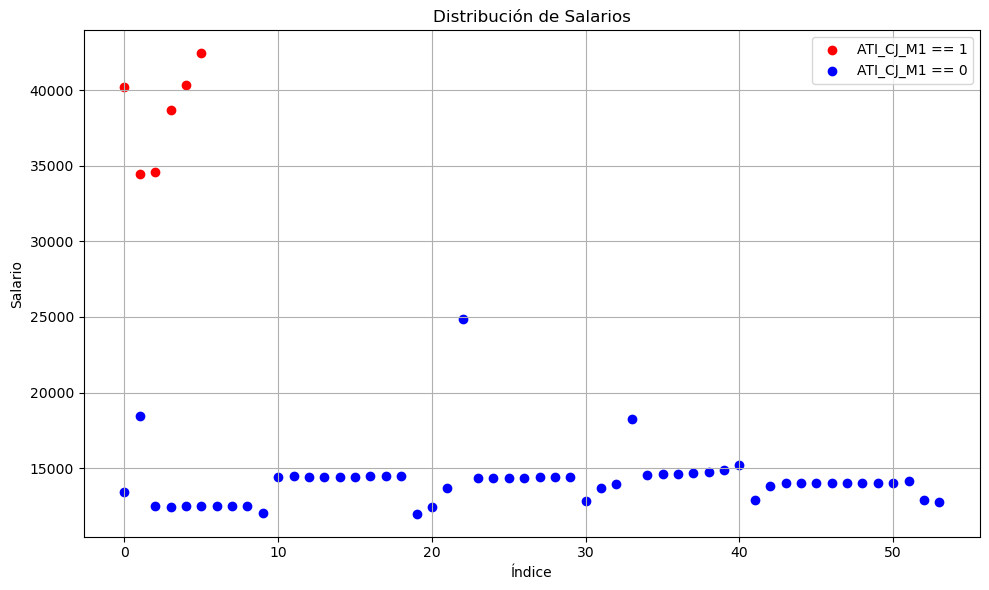

In [85]:
aux=data_l[(data_l['CEDULA_COD']==23594465) & (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==1)]['SALARIO'].reset_index()
aux1 =data_l[(data_l['CEDULA_COD']==23594465) & (data_l['GRUPO_SEL']==1) & (data_l['ATI_CJ_M1']==0)]['SALARIO'].reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(aux.index, aux['SALARIO'], color='r', label='ATI_CJ_M1 == 1')
plt.scatter(aux1.index, aux1['SALARIO'], color='b', label='ATI_CJ_M1 == 0')
plt.title('Distribución de Salarios')
plt.xlabel('Índice')
plt.ylabel('Salario')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()


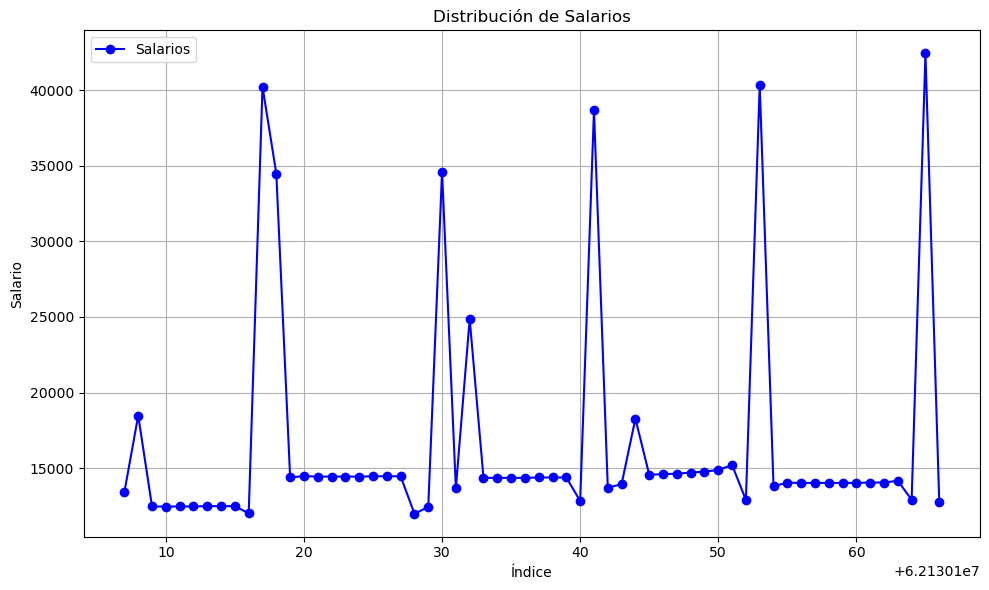

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(data_l[(data_l['CEDULA_COD']==23594465) & (data_l['GRUPO_SEL']==1)]['SALARIO'], marker='o', linestyle='-', color='b', label='Salarios')  # Graficar como línea con puntos
plt.title('Distribución de Salarios')
plt.xlabel('Índice')
plt.ylabel('Salario')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()